In [ ]:

import numpy as np
from IPython.display import Audio
from scipy.signal import resample
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
import os,json
from transformers import  get_scheduler
import wandb
import re
import time

import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM,BitsAndBytesConfig
import evaluate
from datasets import load_dataset,concatenate_datasets
import matplotlib.pyplot as plt
import gc

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def print_gpu_utilization():
    allocated = torch.cuda.memory_allocated() / (1024 ** 2)
    reserved = torch.cuda.memory_reserved() / (1024 ** 2)
    print(f"GPU Memory Usage>>>> Allocated: {allocated:.2f} MB |||||  Reserved:  {reserved:.2f} MB:")

def flush():
    torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.empty_cache()
    gc.collect()

# Load BLEU metric
bleu = evaluate.load("bleu")

# Load tokenizer with source language
tokenizer = AutoTokenizer.from_pretrained("facebook/nllb-200-distilled-600M", src_lang="ory_Orya")

bnb_config = BitsAndBytesConfig(
        load_in_8bit=True,
        bnb_4bit_compute_dtype=torch.bfloat16
    )
model = AutoModelForSeq2SeqLM.from_pretrained(
    "facebook/nllb-200-distilled-600M",
    # quantization_config=bnb_config,
    torch_dtype=torch.bfloat16,
    device_map=device  # Will automatically place on GPU if available
)

# Input article in Odia
article = "ସିରିଆରେ କୌଣସି ସାମରିକ ସମାଧାନ ନାହିଁ ବୋଲି ଜାତିସଂଘ ମୁଖ୍ୟ କହିଛନ୍ତି"

# Tokenize input
inputs = tokenizer(article, return_tensors="pt").to(model.device)

# Generate translation in English
translated_tokens = model.generate(
    **inputs, 
    forced_bos_token_id=tokenizer.convert_tokens_to_ids("eng_Latn"), 
    max_length=30
)

# Decode the output
translation = tokenizer.batch_decode(translated_tokens, skip_special_tokens=True)[0]
print(translation)
print_gpu_utilization()


2025-05-13 12:28:30.808873: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747139310.817722 1256557 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747139310.820411 1256557 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-13 12:28:30.829979: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


UN chief says there is no military solution in Syria
GPU Memory Usage>>>> Allocated: 1185.29 MB |||||  Reserved:  2682.00 MB:


# EDA

In [2]:
predictions = ["hello there general kenobi"]
references = ["hello there general kenobi potato"]
 
bleu = evaluate.load("bleu")
results = bleu.compute(predictions=predictions, references=references)
print(results)
{'bleu': 1.0, 'precisions': [1.0, 1.0, 1.0, 1.0], 'brevity_penalty': 1.0, 'length_ratio': 1.1666666666666667, 'translation_length': 7, 'reference_length': 6}

{'bleu': 0.7788007830714049, 'precisions': [1.0, 1.0, 1.0, 1.0], 'brevity_penalty': 0.7788007830714049, 'length_ratio': 0.8, 'translation_length': 4, 'reference_length': 5}


{'bleu': 1.0,
 'precisions': [1.0, 1.0, 1.0, 1.0],
 'brevity_penalty': 1.0,
 'length_ratio': 1.1666666666666667,
 'translation_length': 7,
 'reference_length': 6}

In [3]:


asr_dataset = load_dataset("Mohan-diffuser/odia-english-ASR")

In [5]:
combined_dataset = concatenate_datasets([asr_dataset['train'], asr_dataset['test']])

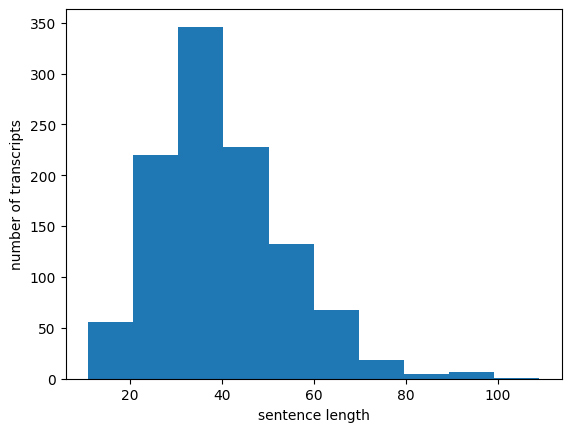

In [6]:
list_of_transcription_lengths = []

tokenized_text = tokenizer(asr_dataset['train']['transcription']).input_ids

for text in tokenized_text:
    list_of_transcription_lengths.append(len(text))
    # break

plt.hist(list_of_transcription_lengths)
plt.xlabel("sentence length")
plt.ylabel("number of transcripts")
plt.show()

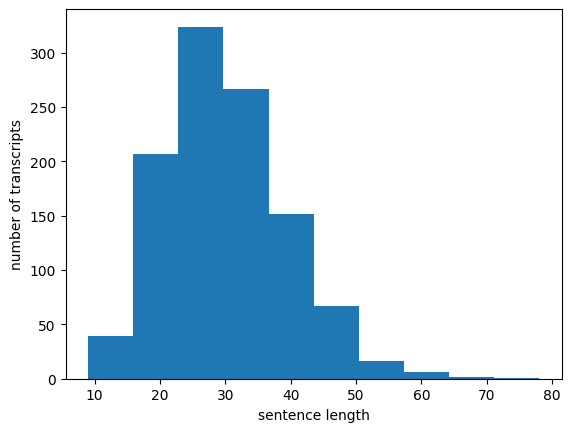

In [7]:
list_of_transcription_lengths = []

tokenized_text = tokenizer(asr_dataset['train']['eng_translation']).input_ids

for text in tokenized_text:
    list_of_transcription_lengths.append(len(text))
    # break

plt.hist(list_of_transcription_lengths)
plt.xlabel("sentence length")
plt.ylabel("number of transcripts")
plt.show()

In [8]:
predictions = []
references = []

counter=0
for sample in tqdm(asr_dataset['validation']):
    if counter>100:
        break
    counter+=1
    odia_text = sample['transcription']
    true_translation = sample['eng_translation']

    # Tokenize and send to device
    inputs = tokenizer(odia_text, return_tensors="pt").to(model.device)

    # Generate translation
    translated_tokens = model.generate(
        **inputs, 
        forced_bos_token_id=tokenizer.convert_tokens_to_ids("eng_Latn"), 
        max_length=80
    )

    # Decode
    translation = tokenizer.batch_decode(translated_tokens, skip_special_tokens=True)[0]

    predictions.append(translation)
    references.append(true_translation)

# Now compute BLEU once
bleu_score = bleu.compute(predictions=predictions, references=references)['bleu']
print(f"BLEU score on test set: {bleu_score:.4f}")

 26%|██▌       | 101/392 [00:17<00:50,  5.72it/s]

BLEU score on test set: 0.4528


# Preprocess the dataset

In [9]:
def preprocess(example):
    # Prepend source language token
    input_text = example['transcription']
    target_text = example['eng_translation']
    
    
    tokenizer.src_lang = "ory_Orya"
    inputs = tokenizer(input_text, truncation=True,padding='max_length', max_length=80, return_tensors="pt")
    tokenizer.src_lang = "eng_Latn"
    targets = tokenizer(target_text, truncation=True,padding='max_length',max_length=60, return_tensors="pt")

    input_ids = inputs["input_ids"].squeeze(0)
    attention_mask = inputs["attention_mask"].squeeze(0)
    labels = targets["input_ids"].squeeze(0)

    # Replace padding token id's of the labels by -100 so they are ignored in loss
    labels[labels == tokenizer.pad_token_id] = -100

    return input_ids, attention_mask, labels


class TranslationDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return preprocess(self.data[idx])


In [10]:
def compute_eval_BLEU():

    predictions = []
    references = []
    model.config.use_cache = True
    model.eval()

    counter=0
    for sample in tqdm(asr_dataset['validation']):
        if counter>100:
            break
        counter+=1
        odia_text = sample['transcription']
        true_translation = sample['eng_translation']

        # Tokenize and send to device
        tokenizer.src_lang = "ory_Orya"
        inputs = tokenizer(odia_text, return_tensors="pt").to(model.device)

        # Generate translation
        translated_tokens = model.generate(
            **inputs, 
            forced_bos_token_id=tokenizer.convert_tokens_to_ids("eng_Latn"), 
            max_length=80
        )

        # Decode
        translation = tokenizer.batch_decode(translated_tokens, skip_special_tokens=True)[0]

        predictions.append(translation)
        references.append(true_translation)

    # Now compute BLEU once
    bleu_score = bleu.compute(predictions=predictions, references=references)['bleu']
    return bleu_score

In [11]:
train_dataset = TranslationDataset(combined_dataset)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

test_dataset= TranslationDataset(asr_dataset['validation'])
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print(f'total setps for 1 epoch: {len(train_loader)}')

for batch in train_loader:
    print(batch)
    break

total setps for 1 epoch: 246
[tensor([[256136,  19333, 179071, 248519,  33504,   1302,  82430, 109610,  39384,
          12862,  13205,  12528,  36579,  10523, 248653,  47563,  39384,  12862,
          13205, 248322,  14206, 248295,  50868,  88700, 137278,   3638,   7501,
         120209,      2,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1],
        [256136,   1750,   2660,  10523, 231525, 248590,  88101,  25751,  19541,
          64808, 134998,  10057,  29479, 248689,  25651, 187802,  17488, 181812,
         248880,  97193,   5165, 229901,  44976,  12528,  70034,  77001,  21986,
     

In [73]:
import torch
from torch.optim import AdamW

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5,  weight_decay=0.001)

model.train()
for epoch in range(1):
    for batch in tqdm(train_loader,total=len(train_loader)):
        
        model.config.use_cache = False
        model.train()
        input_ids, attention_mask, labels = [x.to(device) for x in batch]

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

    print(f"Epoch {epoch+1} Loss: {loss.item():.4f}")


100%|██████████| 246/246 [00:20<00:00, 11.72it/s]

Epoch 1 Loss: 0.7930


In [16]:
import torch
from torch.optim import AdamW

os.makedirs('runs_translation', exist_ok=True)

model.train()
MAX_STEPS=5000
gradient_accumulation_steps=4
eval_steps=500

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5,  weight_decay=0.001)


lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=20,
    num_training_steps=MAX_STEPS,
)



global_step=0


running_bleu=[]
running_loss_buffer=[]
val_losses=[]
train_losses=[]


pbar = tqdm(np.arange(MAX_STEPS), total=MAX_STEPS, leave=False)

while global_step < MAX_STEPS:

    for step, batch in enumerate(train_loader):
        if global_step >= MAX_STEPS:
            break  # Exit the loop early if max steps reached

        model.config.use_cache = False
        model.train()

        input_ids, attention_mask, labels = [x.to(device) for x in batch]

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        running_loss_buffer.append(loss.item())

        # Show current loss in progress bar
        global_step += 1
        pbar.update(1)
        pbar.set_postfix(loss=f"{loss.item():.4f}")



        loss = loss / gradient_accumulation_steps  # Scale the loss
        loss.backward()

        if (step + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            

        if global_step % eval_steps == 0:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for val_batch in tqdm(test_loader, total=len(test_loader), leave=False):
                    input_ids, attention_mask, labels = [x.to(device) for x in val_batch]
                    val_outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                    val_loss += val_outputs.loss.item()
            val_loss /= len(test_loader)
            val_losses.append(val_loss)
            train_losses.append(np.mean(running_loss_buffer[-int(eval_steps * gradient_accumulation_steps):]))


            plt.plot(train_losses, label='train loss', color='blue')
            plt.plot(val_losses, label='test loss', color='red')
            plt.xlabel('steps')
            plt.ylabel('loss')
            plt.legend()
            plt.tight_layout()
            plt.savefig('runs_translation/loss.png')
            plt.close()
            
            running_bleu.append({"step": global_step, "bleu": compute_eval_BLEU()})
            with open('runs_translation/running_bleu.json', 'w') as f:
                json.dump(running_bleu, f, indent=2)



            flush()

 64%|██████▎   | 3186/5000 [06:07<02:37, 11.55it/s, loss=0.5977]  

KeyboardInterrupt: 

In [17]:
model.save_pretrained("runs_translation/odia_english_ckpt")

/home/mohan.dash/miniconda3/envs/buawei/lib/python3.10/site-packages/transformers/modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 200}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
